In [6]:
from github import Github
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

url = "HikaGenji/hl-dl"
g = Github()  # No authentication needed for public repos, but you can add a token for higher rate limits
repo = g.get_repo(url)
contents = repo.get_contents("data")
files = [content_file.path for content_file in contents]

In [5]:
import duckdb

parquet_url = [f"https://github.com/{url}/raw/main/{f}" for f in files]

# Example query: select columns and filter rows
result = duckdb.query(f"SELECT * FROM read_parquet({parquet_url})").pl()

print(result.head())


shape: (5, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ ethAddres ┆ accountVa ┆ displayNa ┆ … ┆ month_vol ┆ allTime_p ┆ allTime_r ┆ allTime_ │
│ ---       ┆ s         ┆ lue       ┆ me        ┆   ┆ ume       ┆ nl        ┆ oi        ┆ volume   │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ str       ┆ f64       ┆ str       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2025-06-0 ┆ 0x162cc7c ┆ 2.4187e7  ┆ ABC       ┆ … ┆ 4.1088e10 ┆ 2.0885e7  ┆ 1.394246  ┆ 1.2319e1 │
│ 8T08:44:1 ┆ 861ebd0c0 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 1        │
│ 6.170503  ┆ 6b3d72319 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 201…      ┆           ┆           ┆   ┆           ┆           

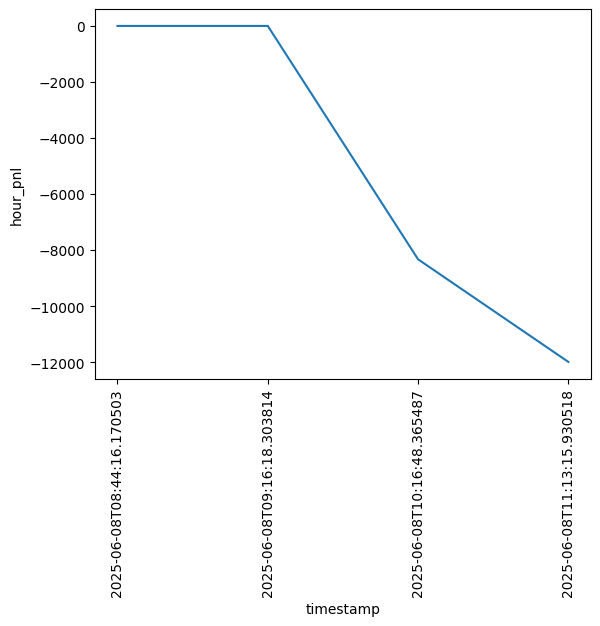

In [8]:
user = '0x162cc7c861ebd0c06b3d72319201150482518185'
p = result.filter(pl.col('ethAddress')==user).select('timestamp', pl.col('day_pnl')).\
           with_columns(pl.col('day_pnl').sub(pl.col('day_pnl').first()).fill_null(0).alias('hour_pnl'))
sns.lineplot(
    data=p,
    x="timestamp",
    y="hour_pnl"
)
plt.xticks(rotation=90)
plt.show()